In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

df = pd.read_csv("daily_price_dataset.csv")


In [10]:
print("Shape:", df.shape)
print("\nColumn Names:\n", df.columns)

df.info()
df.describe(include='all')


Shape: (631, 10)

Column Names:
 Index(['date', 'amazon_price', 'amazon_discount', 'flipkart_price',
       'flipkart_discount', 'day', 'month', 'year', 'weekend', 'datetime'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631 entries, 0 to 630
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               631 non-null    object 
 1   amazon_price       631 non-null    float64
 2   amazon_discount    631 non-null    object 
 3   flipkart_price     631 non-null    float64
 4   flipkart_discount  631 non-null    object 
 5   day                631 non-null    int64  
 6   month              631 non-null    int64  
 7   year               631 non-null    int64  
 8   weekend            631 non-null    bool   
 9   datetime           631 non-null    object 
dtypes: bool(1), float64(2), int64(3), object(4)
memory usage: 45.1+ KB


,date,amazon_price,amazon_discount,flipkart_price,flipkart_discount,day,month,year,weekend,datetime
count,631,631.000000,631,631.000000,631,631.000000,631.000000,631.000000,631,631
unique,631,NaN,61,NaN,44,NaN,NaN,NaN,2,631
top,2025-09-22,NaN,22.25%,NaN,18.77%,NaN,NaN,NaN,False,2025-09-22 19:26:37
freq,1,NaN,37,NaN,102,NaN,NaN,NaN,451,1
mean,NaN,66646.966719,NaN,65310.611727,NaN,15.587956,5.835182,2024.419968,NaN,NaN
std,NaN,5574.656496,NaN,4545.438830,NaN,8.770701,3.198427,0.493945,NaN,NaN
min,NaN,46999.000000,NaN,54999.000000,NaN,1.000000,1.000000,2024.000000,NaN,NaN
25%,NaN,61400.000000,NaN,63999.000000,NaN,8.000000,3.000000,2024.000000,NaN,NaN
50%,NaN,66900.000000,NaN,64900.000000,NaN,16.000000,6.000000,2024.000000,NaN,NaN
75%,NaN,71290.000000,NaN,67499.000000,NaN,23.000000,8.000000,2025.000000,NaN,NaN


In [11]:
print("\nMissing Values:\n")
print(df.isnull().sum())



Missing Values:

date                 0
amazon_price         0
amazon_discount      0
flipkart_price       0
flipkart_discount    0
day                  0
month                0
year                 0
weekend              0
datetime             0
dtype: int64


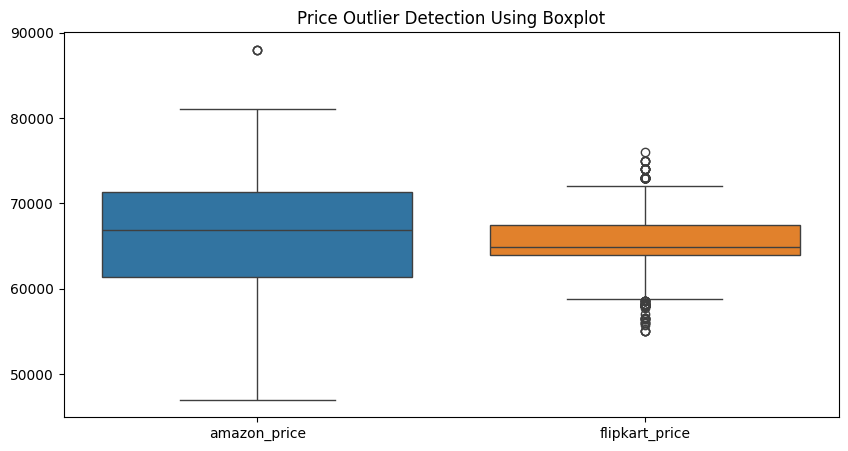

In [12]:
plt.figure(figsize=(10,5))
sns.boxplot(df[["amazon_price", "flipkart_price"]])
plt.title("Price Outlier Detection Using Boxplot")
plt.show()


In [13]:

Q1_f = df['flipkart_price'].quantile(0.25)
Q3_f = df['flipkart_price'].quantile(0.75)
IQR_f = Q3_f - Q1_f

# Special case: flat/constant values
if IQR_f == 0:
    lower_f = Q1_f - 1
    upper_f = Q3_f + 1
else:
    lower_f = Q1_f - 1.5 * IQR_f
    upper_f = Q3_f + 1.5 * IQR_f

flipkart_outliers = df[
    (df['flipkart_price'] < lower_f) |
    (df['flipkart_price'] > upper_f)
]

print("Flipkart Outliers Count:", flipkart_outliers.shape[0])


import numpy as np

Q1_a = df['amazon_price'].quantile(0.25)
Q3_a = df['amazon_price'].quantile(0.75)
IQR_a = Q3_a - Q1_a

# Special case: flat/constant values
if IQR_a == 0:
    lower_a = Q1_a - 1
    upper_a = Q3_a + 1
else:
    lower_a = Q1_a - 1.5 * IQR_a
    upper_a = Q3_a + 1.5 * IQR_a

flipkart_outliers = df[
    (df['amazon_price'] < lower_a) |
    (df['amazon_price'] > upper_a)
]

print("Amazon Outliers Count:", flipkart_outliers.shape[0])



Flipkart Outliers Count: 107
Amazon Outliers Count: 3


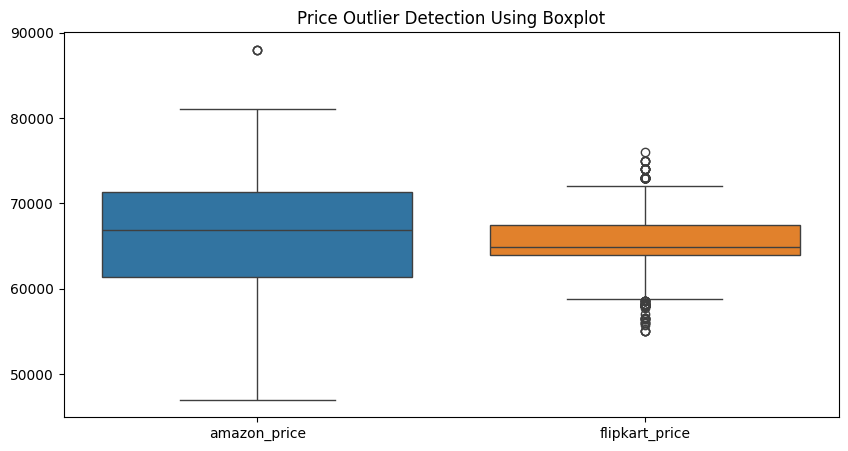

In [14]:
plt.figure(figsize=(10,5))
sns.boxplot(df[["amazon_price", "flipkart_price"]])
plt.title("Price Outlier Detection Using Boxplot")
plt.show()


In [15]:
df['date'] = pd.to_datetime(df['date'])
df['amazon_price'] = pd.to_numeric(df['amazon_price'], errors='coerce')
df['flipkart_price'] = pd.to_numeric(df['flipkart_price'], errors='coerce')

# convert discount percentage columns
df['amazon_discount'] = df['amazon_discount'].str.replace('%', '').astype(float)
df['flipkart_discount'] = df['flipkart_discount'].str.replace('%', '').astype(float)


For Amazon

In [16]:
target_col = "amazon_price"

ts = df[target_col].dropna()

In [17]:

# -----------------------------
# 3️⃣ TEST STATIONARITY (ADF Test)
# -----------------------------
result = adfuller(ts.dropna())
print("ADF Test Result:")
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
if result[1] > 0.05:
    print("❌ NOT STATIONARY → Apply differencing or use ML Models")
else:
    print("✅ Stationary → Can use ARIMA models")

ADF Test Result:
ADF Statistic: -0.7954449606710039
p-value: 0.8204564155038674
❌ NOT STATIONARY → Apply differencing or use ML Models


<Figure size 800x400 with 0 Axes>

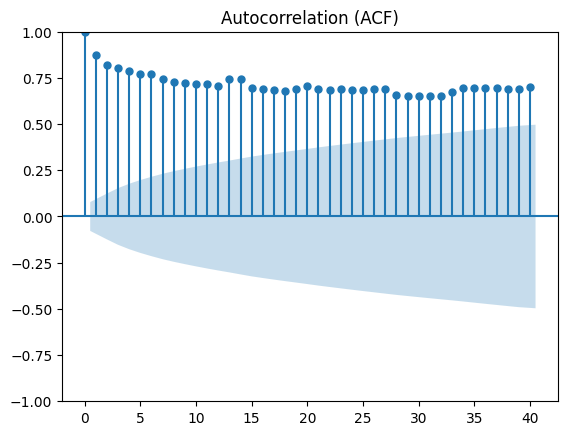

<Figure size 800x400 with 0 Axes>

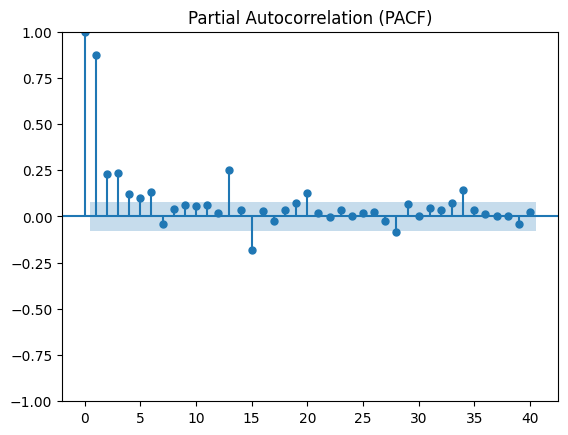

In [18]:
plt.figure(figsize=(8,4))
plot_acf(ts, lags=40)
plt.title("Autocorrelation (ACF)")
plt.show()

# --------------------------------------------------------
# 6. PACF PLOT
# --------------------------------------------------------
plt.figure(figsize=(8,4))
plot_pacf(ts, lags=40, method="ywm")
plt.title("Partial Autocorrelation (PACF)")
plt.show()

For Flipkart

In [19]:
target_col = "flipkart_price"

ts = df[target_col].dropna()

In [20]:

# -----------------------------
# 3️⃣ TEST STATIONARITY (ADF Test)
# -----------------------------
result = adfuller(ts.dropna())
print("ADF Test Result:")
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
if result[1] > 0.05:
    print("❌ NOT STATIONARY → Apply differencing or use SARIMA/Prophet")
else:
    print("✅ Stationary → Can use ARIMA models")

ADF Test Result:
ADF Statistic: -2.674805005379289
p-value: 0.07850049426527941
❌ NOT STATIONARY → Apply differencing or use SARIMA/Prophet


<Figure size 800x400 with 0 Axes>

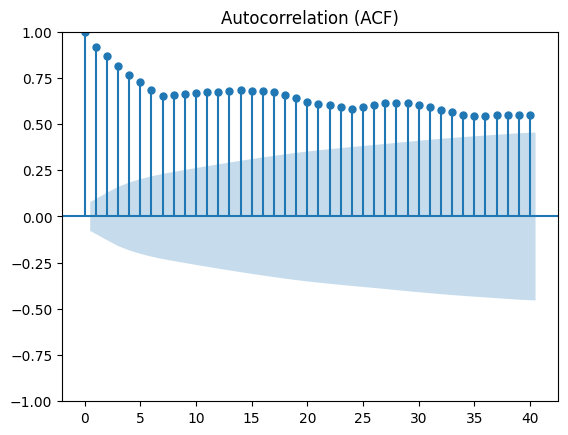

<Figure size 800x400 with 0 Axes>

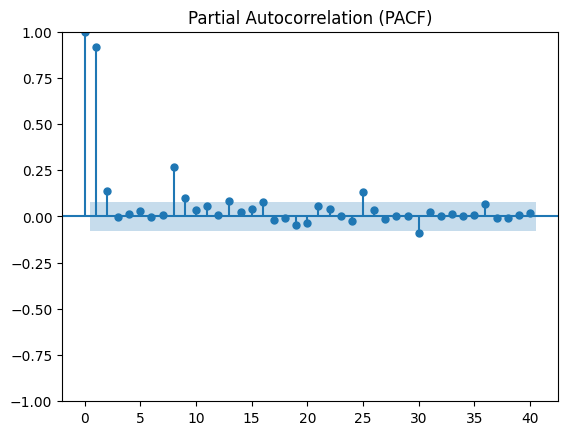

In [21]:
plt.figure(figsize=(8,4))
plot_acf(ts, lags=40)
plt.title("Autocorrelation (ACF)")
plt.show()

# --------------------------------------------------------
# 6. PACF PLOT
# --------------------------------------------------------
plt.figure(figsize=(8,4))
plot_pacf(ts, lags=40, method="ywm")
plt.title("Partial Autocorrelation (PACF)")
plt.show()

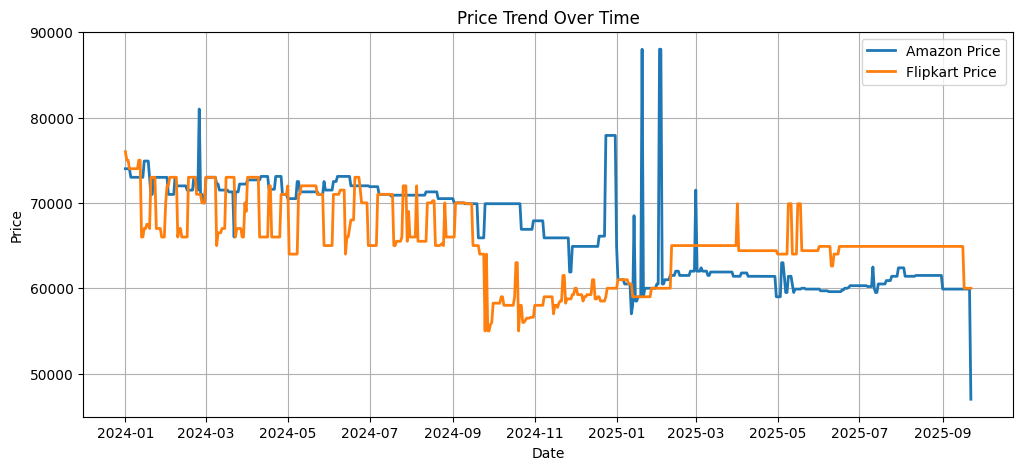

In [22]:
plt.figure(figsize=(12,5))
plt.plot(df['date'], df['amazon_price'], label='Amazon Price', linewidth=2)
plt.plot(df['date'], df['flipkart_price'], label='Flipkart Price', linewidth=2)
plt.title("Price Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()


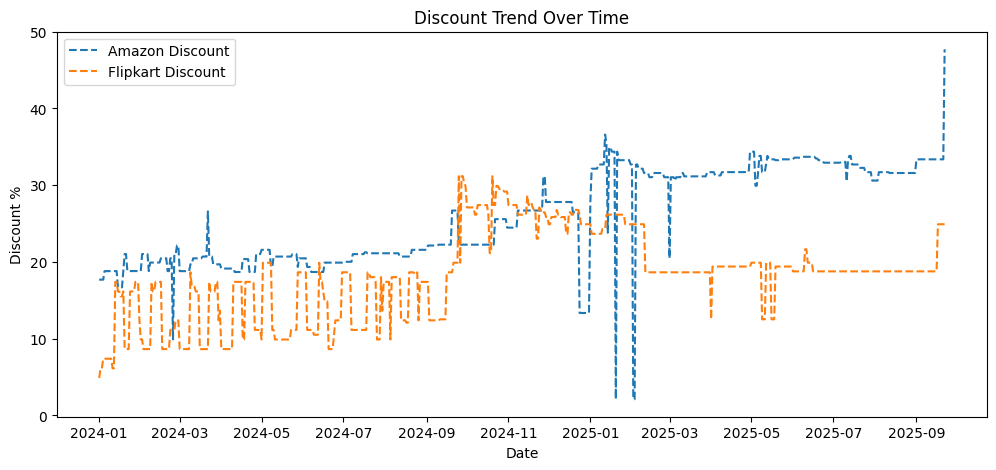

In [23]:
plt.figure(figsize=(12,5))
plt.plot(df['date'], df['amazon_discount'], label='Amazon Discount', linestyle='--')
plt.plot(df['date'], df['flipkart_discount'], label='Flipkart Discount', linestyle='--')
plt.title("Discount Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Discount %")
plt.legend()
plt.show()


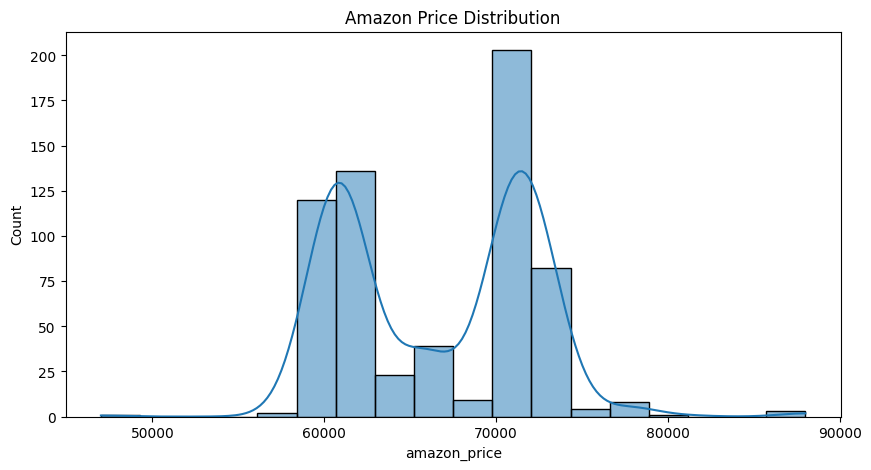

In [24]:
plt.figure(figsize=(10,5))
sns.histplot(df['amazon_price'], kde=True)
plt.title("Amazon Price Distribution")
plt.show()


In [25]:
# -----------------------------
# 4️⃣ CORRELATION CHECK (Lag Relationship)
# -----------------------------
lag_corr = ts.autocorr(lag=1)
print("\nLag-1 Autocorrelation:", lag_corr)
if lag_corr > 0.5:
    print("📌 Strong lag effect → Lags are useful features for ML models")
else:
    print("ℹ Lag impact is weak")


Lag-1 Autocorrelation: 0.9248385327803702
📌 Strong lag effect → Lags are useful features for ML models


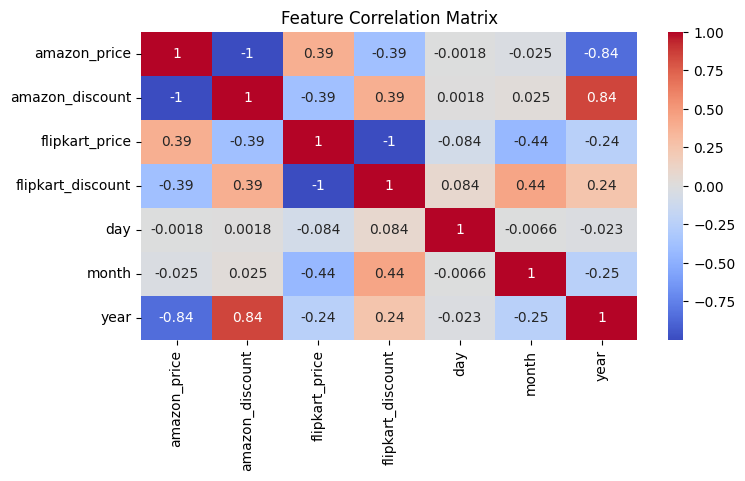

In [26]:
numeric_df = df.select_dtypes(include=['int64','float64'])
plt.figure(figsize=(8,4))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


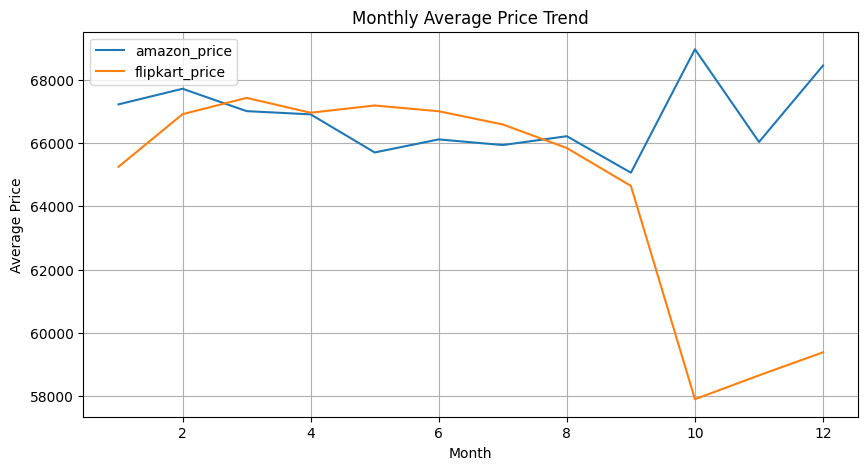

In [27]:
monthly = df.groupby('month')[['amazon_price','flipkart_price']].mean()

monthly.plot(figsize=(10,5))
plt.title("Monthly Average Price Trend")
plt.xlabel("Month")
plt.ylabel("Average Price")
plt.grid()
plt.show()


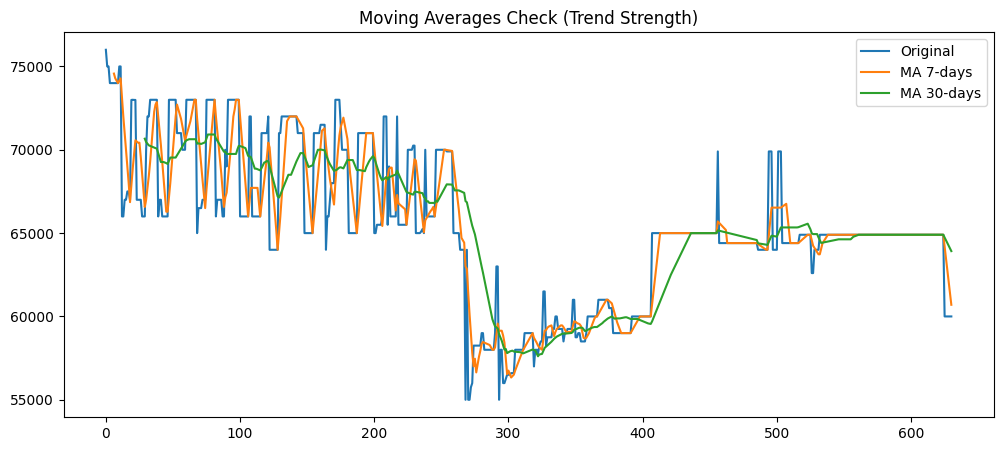

In [28]:
# -----------------------------
# 7️⃣ FEATURE IMPORTANCE CHECK (Rolling Statistics)
# -----------------------------
df['MA_7'] = ts.rolling(window=7).mean()
df['MA_30'] = ts.rolling(window=30).mean()

plt.figure(figsize=(12,5))
plt.plot(ts, label="Original")
plt.plot(df['MA_7'], label="MA 7-days")
plt.plot(df['MA_30'], label="MA 30-days")
plt.legend()
plt.title("Moving Averages Check (Trend Strength)")
plt.show()

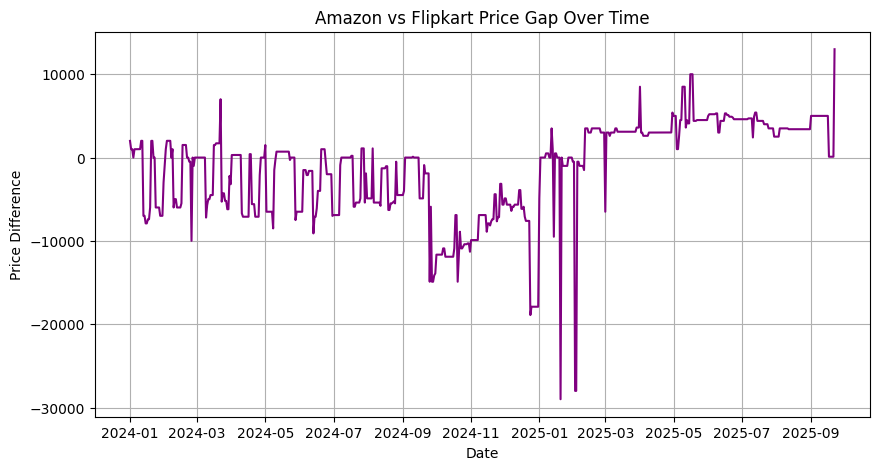

In [29]:
df["price_gap"] = df["flipkart_price"] - df["amazon_price"]

plt.figure(figsize=(10,5))
plt.plot(df['date'], df['price_gap'], label='Price Difference', color='purple')
plt.title("Amazon vs Flipkart Price Gap Over Time")
plt.xlabel("Date")
plt.ylabel("Price Difference")
plt.grid()
plt.show()
